In [1]:
%load_ext autoreload
%autoreload 2

from source.read_HAR_dataset import read_har_dataset, har_dimensions, har_activities, har_activities_map, har_ind_IDS
from source.utils import idsStd, filter_dimensions
from xgboost import XGBClassifier
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from source.tserie import TSerie

N_COMPONENTS=32
Z_SCORE_NORM = False
DATASET = 'HAR-UML20'
KFOLDS = 1
METRIC  = 'braycurtis'
N_TESTS = 2
sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage


In [2]:
def minoritySampling(X, y):
    rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
    N, T, D = X.shape
    X_temp = X.reshape([N, T * D])
    X_temp, y = rus.fit_resample(X_temp, y)
    X = X_temp.reshape([X_temp.shape[0], T, D])
    return X, y

har_activities_map = {
    0: "Sedentary",
    1: "Walking",
    2: "Running",
    3: "Downstairs",
    4: "Upstairs"
}
def load_data(k):
    all_ids = har_ind_IDS
    test_ids = all_ids[k: k + N_TESTS]
    train_ids = all_ids[:k] + all_ids[k + N_TESTS:]        
    
    data = read_har_dataset('./datasets/HAR-UML20/', train_ids=train_ids, test_ids=test_ids, val_ids=[], cache=True)
    ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']
    # ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']
    ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']
    
    

    all_dimensions = har_dimensions
    activities_map = har_activities_map
    
    y_train[y_train==0] = 0
    y_train[y_train==1] = 0
    y_train[y_train==2] = 0
    y_test[y_test==0] = 0
    y_test[y_test==1] = 0
    y_test[y_test==2] = 0

    for i in range(3, len(har_activities)):
        y_train[y_train==i] = i - 2
        y_test[y_test==i] = i - 2
    
    ind_std_train = idsStd(train_ids , X_train, I_train)
    ind_std_test = idsStd(test_ids, X_test, I_test)
    
    unique, counts = np.unique(y_train, return_counts=True)
    unique, counts = np.unique(y_test, return_counts=True)
    
    I_train = np.expand_dims(I_train, axis=1)
    I_test = np.expand_dims(I_test, axis=1)
    ltrain = np.arange(len(y_train))
    ltest = np.arange(len(y_test))
    
    X_train, zlabels_train = minoritySampling(X_train, ltrain)
    X_test, zlabels_test = minoritySampling(X_test, ltest)
    
    y_train = y_train[ltrain]
    I_train = I_train[ltrain]
    y_test = y_test[ltest]
    I_test = I_test[ltest]
    
    return X_train, y_train, I_train, X_test, y_test, I_test

In [3]:
X_train, y_train, I_train, X_test, y_test, I_test = load_data(0)

Train IDS: [2, 3, 4, 5, 6, 7, 8, 9]
Test IDS: [0, 1]
Val IDS: []
Loading dataset from cache...


In [4]:
dimensions = [
    'Accelerometer-X',	
    'Accelerometer-Y',	
    'Accelerometer-Z',
    'Gyrometer-X',
    'Gyrometer-Y',
    'Gyrometer-Z'
]

X_train = filter_dimensions(X_train, har_dimensions, dimensions)
X_test = filter_dimensions(X_test, har_dimensions, dimensions)

mts_train = TSerie(X = X_train, y = y_train, I = I_train, dimensions = dimensions, classLabels=har_activities_map)
mts_test = TSerie(X = X_test, y = y_test, I = I_test, dimensions = dimensions, classLabels=har_activities_map)




minl, maxl = mts_train.minMaxNormalization()
mts_test.minMaxNormalization(minl=minl, maxl=maxl)

# mts_train.center([0,1,2,3,4,5])
# mts_test.center([0,1,2,3,4,5])



([-3.5, -6.32, -4.098, -1410.6447, -1878.412, -436.52347],
 [4.301, 1.195, 2.195, 1567.0778, 1417.0656, 601.52106])

[4]
(1, 200, 3)
(1, 200, 3)


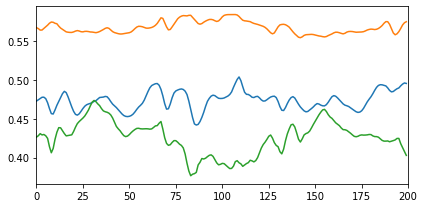

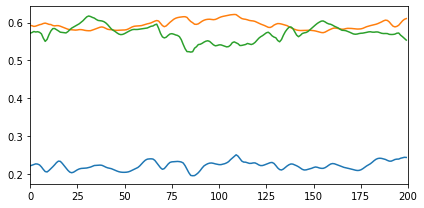

/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


(0.0, 1.0)

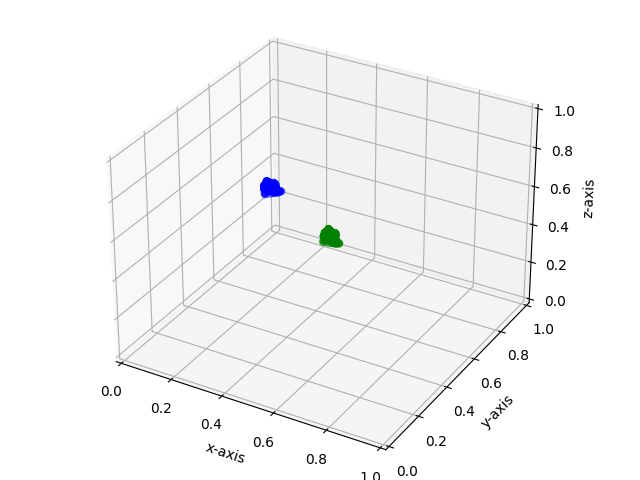

In [5]:
from source.augmentation import  * 
from source.utils import plot1d
import matplotlib.pyplot as plt

# window = mts_train.X[130, :, 3]
n = 880
print(mts_train.y[n])
# window_arr = np.array([mts_train.X[n, :, 0], mts_train.X[n, :, 1], mts_train.X[n, :, 2]])
window_arr = np.array([mts_train.X[n, :, 3], mts_train.X[n, :, 4], mts_train.X[n, :, 5]])
window_arr = np.expand_dims(window_arr, axis=0)
window_arr = np.transpose(window_arr, [0, 2, 1])
print(window_arr.shape)

# window_rot = flipping(window_arr)
window_rot = rotation(window_arr, angle_range=[-np.pi/4, np.pi/4])

print(window_rot.shape)
plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_rot[0, :, 0], window_rot[0, :, 1], window_rot[0, :, 2])



%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = Axes3D(fig)

# creating the plot
plot_geeks = ax.scatter(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2], color='green')
plot_geeks = ax.scatter(window_rot[0, :, 0], window_rot[0, :, 1], window_rot[0, :, 2], color='blue')
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
# ax.axes.set_xlim3d(left=0, right=1)
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 


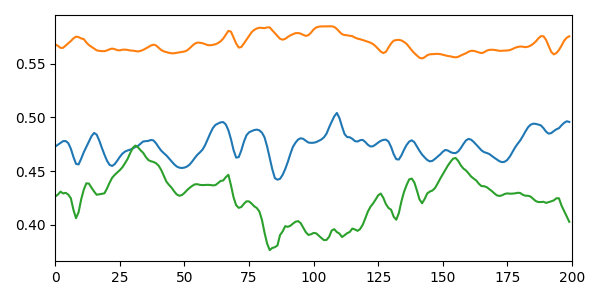

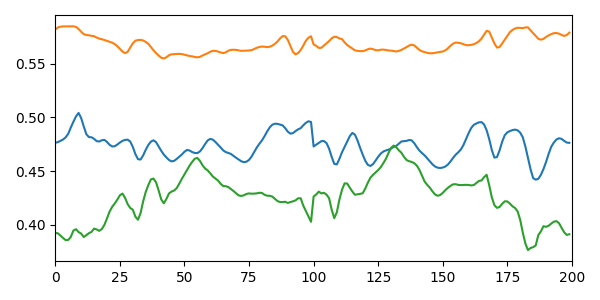

In [86]:
from source.augmentation import  * 
from source.utils import plot1d

window_perm = permutation(window_arr)

plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_perm[0, :, 0], window_perm[0, :, 1], window_perm[0, :, 2])



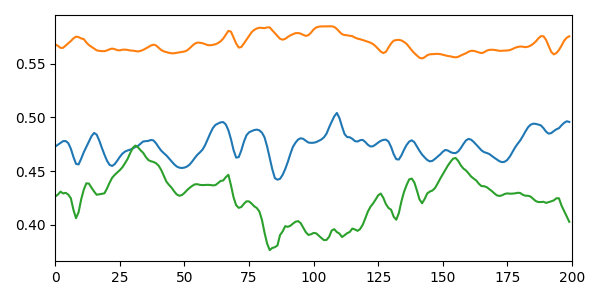

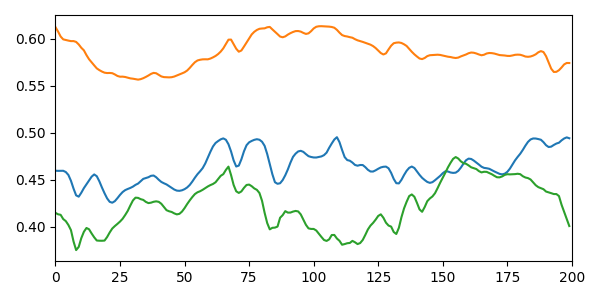

In [95]:
window_magw = magnitude_warp(window_arr, sigma=0.04, knot=4)

plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_magw[0, :, 0], window_magw[0, :, 1], window_magw[0, :, 2])

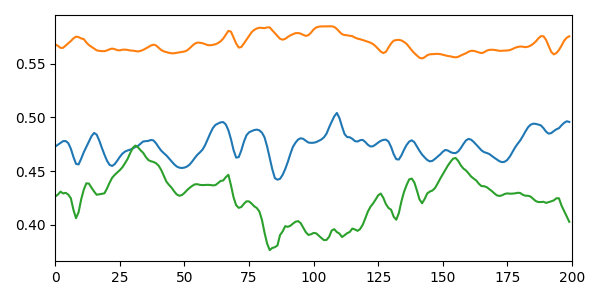

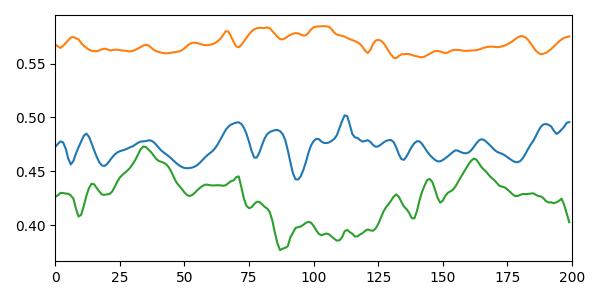

In [103]:
from source.augmentation import  * 
window_timw = time_warp(window_arr, sigma=0.03)

plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_timw[0, :, 0], window_timw[0, :, 1], window_timw[0, :, 2])

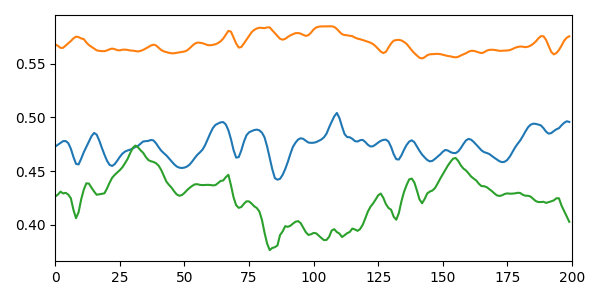

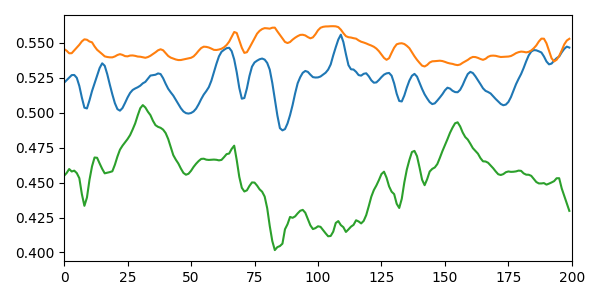

In [107]:
window_scal = scaling(window_arr, sigma=0.05)

plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_scal[0, :, 0], window_scal[0, :, 1], window_scal[0, :, 2])

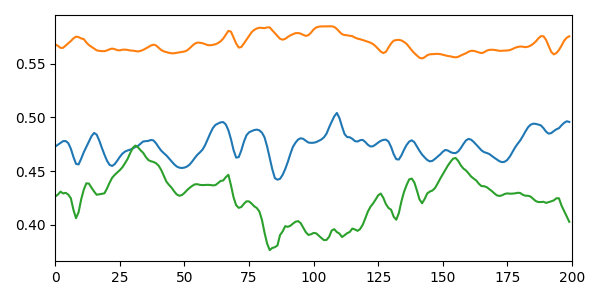

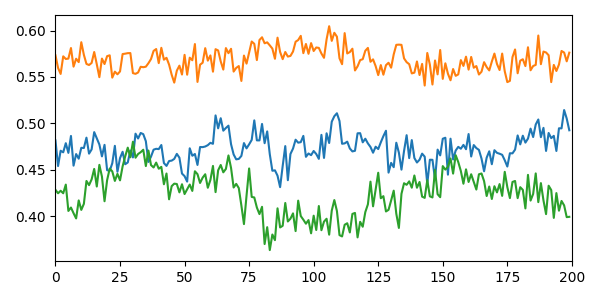

In [114]:
window_jit = jitter(window_arr, sigma=0.01)

plot1d(window_arr[0, :, 0], window_arr[0, :, 1], window_arr[0, :, 2])
plot1d(window_jit[0, :, 0], window_jit[0, :, 1], window_jit[0, :, 2])

In [62]:
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP


class FeatureExtractor:
    def __init__(self, n_components, n_neighbors):
        self.reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, n_epochs=2000)
        self.nearNeigh = NearestNeighbors(n_neighbors=n_neighbors, metric=METRIC)

    def fit_transform(self, X, y=None):
        self.nearNeigh.fit(X)
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.fit_transform(X, y=y, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings
    
    def transform(self, X):
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.transform(X, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings

mts_train.znorm([0,1,2,3,4,5])
mts_test.znorm([0,1,2,3,4,5])

mts_train.folding_features_v2()
mts_test.folding_features_v2()

reducer = FeatureExtractor(2, 15)
train_feat = reducer.fit_transform(mts_train.features, mts_train.y)
test_feat = reducer.transform(mts_test.features)

Features shape: (6300, 1200)
Features shape: (2100, 1200)


In [63]:

storage = MTSStorage('har_norm_viz')
# storage.delete()
storage.load()

storage.add_mts(
    'train_viz',
    mts_train.X, 
    dimensions,
    coords={
        'umap': train_feat
    }, 
    labels={
        'activities': mts_train.y, 
        # 'participants': mts_test.I
    }, 
    labelsNames={'activities': har_activities_map },
    sampling = True,
    n_samples = 400
)

storage.add_mts(
    'test_viz',
    mts_test.X, 
    dimensions,
    coords={
        'umap': test_feat
    }, 
    labels={
        'activities': mts_test.y, 
        # 'participants': mts_test.I
    }, 
    labelsNames={'activities': har_activities_map },
    sampling = True,
    n_samples = 400
)
storage.save()

mts shape: N: 6300 -  T: 200 - D: 6
mts shape: N: 2100 -  T: 200 - D: 6
